In [1]:
using  FFTW
using  LinearAlgebra
using  ProgressMeter
using  BenchmarkTools
using  Plots
using  DeepWaterModels

pyplot()

Plots.PyPlotBackend()

In [2]:
abstract type AbstractModel end

mutable struct Cheng <: AbstractModel

    freq    :: Freq
    label   :: String
    Gamma   :: Array{Float64,1}
    Dx      :: Array{Complex{Float64},1}
    H       :: Array{Complex{Float64},1}
    Pi      :: BitArray{1}
    epsilon :: Float64
    hnew    :: Vector{Complex{Float64}}
    unew    :: Vector{Complex{Float64}}
    
    Int1    :: Vector{Complex{Float64}}
    Int2    :: Vector{Complex{Float64}}
    Int3    :: Vector{Complex{Float64}}
    
    Px      :: FFTW.FFTWPlan
        
    function Cheng(freq::Freq, epsilon::Float64)
        label = "Cheng et al."
        Gamma = abs.(freq.k)
        Dx    =  1im * freq.k            # Differentiation
        H     = -1im * sign.(freq.k)     # Hilbert transform
        Pi    = Gamma .< freq.kmax * 2/3 # Dealiasing low-pass filter
        
        hnew = zeros(Complex{Float64}, freq.nk)
        unew = zeros(Complex{Float64}, freq.nk)
    
        Int1 = zeros(Complex{Float64}, freq.nk)
        Int2 = zeros(Complex{Float64}, freq.nk)
        Int3 = zeros(Complex{Float64}, freq.nk)
        
        Px  = plan_fft(hnew; flags = FFTW.MEASURE)
      
        new(freq, label, Gamma, Dx, H, Pi, epsilon,
            hnew, unew, Int1, Int2, Int3, Px)
        
    end
end

function (m::Cheng)(h::Vector{Complex{Float64}},
                    u::Vector{Complex{Float64}})
         
    ldiv!(m.hnew, m.Px , h)
    
    m.Int1  .= u
    m.Int1 .*= m.Gamma
    ldiv!(m.unew, m.Px , m.Int1)
    m.unew  .^= 2
    mul!(m.Int1, m.Px , m.unew)
    m.Int1 .*= m.H
    
    m.Int2  .= h
    m.Int2 .*= m.Dx
    ldiv!(m.unew, m.Px , m.Int2)
    m.unew  .*= m.hnew
    mul!(m.Int2, m.Px , m.unew)
    
    m.Int3  .= h
    m.Int3 .*= m.Gamma
    ldiv!(m.unew, m.Px, m.Int3)
    m.unew  .*= m.hnew
    mul!(m.Int3 , m.Px , m.unew)
    m.Int3 .*= m.H
    
    m.hnew  .= -u
    m.hnew .*= m.Dx
    
    m.Int1 .-= m.Int2
    m.Int1 .-= m.Int3
    m.Int1 .*= m.Pi
    m.Int1 .*= m.epsilon
    
    u  .= h
    u .*= m.H
    u .+= m.Int1
    
    h .= m.hnew
             
end



In [3]:
mutable struct Matsuno <: AbstractModel
    
    freq    :: Freq
    label   :: String
    Gamma   :: Array{Float64,1}
    Dx      :: Array{Complex{Float64},1}
    H       :: Array{Complex{Float64},1}
    Pi      :: BitArray{1}
    epsilon :: Float64
    hnew    :: Vector{Complex{Float64}}
    unew    :: Vector{Complex{Float64}}
    
    Int1    :: Vector{Complex{Float64}}
    Int2    :: Vector{Complex{Float64}}
    Int3    :: Vector{Complex{Float64}}
    
    Px      :: FFTW.FFTWPlan

    function Matsuno(freq::Freq, epsilon::Float64)
        label = "Matsuno"
        Gamma = abs.(freq.k)
        Dx    =  1im * freq.k            # Differentiation
        H     = -1im * sign.(freq.k)     # Hilbert transform
        Pi    = Gamma .< freq.kmax * 2/3 # Dealiasing low-pass filter
        hnew = zeros(Complex{Float64}, freq.nk)
        unew = zeros(Complex{Float64}, freq.nk)
    
        Int1 = zeros(Complex{Float64}, freq.nk)
        Int2 = zeros(Complex{Float64}, freq.nk)
        Int3 = zeros(Complex{Float64}, freq.nk)
        
        Px  = plan_fft(hnew; flags = FFTW.MEASURE)
      
        new(freq, label, Gamma, Dx, H, Pi, epsilon,
            hnew, unew, Int1, Int2, Int3, Px)
    end
end


function (m::Matsuno)(h::Vector{Complex{Float64}},
                      u::Vector{Complex{Float64}})
    
   # hnew .= real(ifft(h))
   # unew .= real(ifft(u))
   # Int3 .= fft(real(ifft(Dx.*h)).*real(ifft(Gamma.*h)))
 #
   # Int1 .= H.*u-epsilon*Pi.*(H.*fft(hnew.*real(ifft(Gamma.*u))).+Dx.*fft(hnew.*unew))
   # Int2 .= -(Dx.*h)-epsilon/2*Pi.*(Dx.*fft(unew.^2))+epsilon*Pi.*Int3
   # 
   # h .= Int1
   # u .= Int2
     
    m.hnew .= m.Gamma 
    m.hnew .*= h         
    ldiv!(m.unew, m.Px, m.hnew )   
    m.hnew .= m.Dx 
    m.hnew .*= h            
    ldiv!(m.Int1, m.Px, m.hnew)    
    m.unew .*= m.Int1            
    mul!(m.Int1, m.Px, m.unew)     
    m.Int1 .*= m.epsilon*m.Pi
    m.Int2 .= m.Dx .* h
    m.Int1 .-= m.Int2
    ldiv!(m.hnew, m.Px, h)
    ldiv!(m.unew, m.Px, u)
    m.Int2  .= m.hnew .* m.unew
    mul!(m.Int3, m.Px, m.Int2)
    m.Int3 .*= m.Dx
    h     .= m.H.*u
    u    .*= m.Gamma
    ldiv!(m.Int2, m.Px, u)
    m.Int2 .*= m.hnew
    mul!(u, m.Px, m.Int2)
    u    .*= m.H
    m.Int3 .+= u
    m.Int3 .*= m.epsilon * m.Pi
    h    .-= m.Int3     
    m.Int3  .= m.unew.^2
    mul!(m.unew, m.Px, m.Int3)
    m.unew  .*= m.Dx
    m.unew  .*= m.epsilon/2 * m.Pi 
    m.Int1  .-= m.unew
    u .= m.Int1
end
    

In [4]:
function solve(model::AbstractModel, 
        h::Vector{Complex{Float64}}, 
        u::Vector{Complex{Float64}}, 
        times::Times, solver::TimeSolver)
                
    prog = Progress(times.nt,1)
    
    data = []
    push!(data,(h,u))
    for l in range(1,times.nt-1)
        
        dt = times.t[l+1]-times.t[l]
        
        step!( solver, model, h, u, dt)
    
        push!(data,(h,u))   
        next!(prog)
        
    end
    data     
end

solve (generic function with 1 method)

In [5]:
function step!(s  :: RK4,
               f  :: AbstractModel,
               h  :: Vector{Complex{Float64}},
               u  :: Vector{Complex{Float64}},
               dt :: Float64)
        
    s.hhat .= h
    s.uhat .= u
    f( s.hhat, s.uhat)
    s.dh .= s.hhat
    s.du .= s.uhat
    
    s.hhat .= h .+ dt/2*s.hhat
    s.uhat .= u .+ dt/2*s.uhat
    f( s.hhat, s.uhat)
    s.dh .+= 2 * s.hhat
    s.du .+= 2 * s.uhat
    
    s.hhat .= h .+ dt/2*s.hhat
    s.uhat .= u .+ dt/2*s.uhat
    f( s.hhat, s.uhat)
    s.dh .+= 2 * s.hhat
    s.du .+= 2 * s.uhat
    
    s.hhat .= h .+ dt*s.hhat
    s.uhat .= u .+ dt*s.uhat
    f( s.hhat, s.uhat)
    s.dh .+= s.hhat
    s.du .+= s.uhat
    
    h .+= dt/6 * s.dh
    u .+= dt/6 * s.du
end


step! (generic function with 1 method)

In [28]:
function fig(t, times::Times, models::Dict, mesh::Mesh, Gamma, freq)
        
    s = 0
    if indexin(false,times.t.<=t)[1]==nothing
        index=length(times.t)
    else 
        index=indexin(false,times.t.<=t)
    end
    
    p = plot(layout=(2,1))


    for label in keys(models)
    
        (hhat,uhat)=models[label][index]
        (h,u)=(real(ifft((Gamma.^s).*hhat)),real(ifft(uhat)))
        plot!(p[1,1], mesh.x,h; label=string(label))
        plot!(p[2,1], fftshift(freq.k),log10.(1e-18.+abs.(fftshift(hhat))); 
            label=string(label))
    end
    
    p
end


fig (generic function with 2 methods)

In [29]:
epsilon = 1/2
N       = 2^12
L       = 10
T       = 5
dt      = 0.001

@show epsilon,N,L,T,dt

mesh  = Mesh(-L, L, N)
freq  = Freq(mesh.dx, N)
times = Times(dt, T)

solver = RK4( mesh.nx )
h  = zeros(Complex{Float64}, mesh.nx)
u  = zeros(Complex{Float64}, mesh.nx)

Gamma = abs.(freq.k)
Pi    = Gamma .< freq.kmax * 2/3;



(epsilon, N, L, T, dt) = (0.5, 4096, 10, 5, 0.001)


Progress:  96%|███████████████████████████████████████  |  ETA: 0:00:00

  6.246809 seconds (551.18 k allocations: 5.519 GiB, 9.04% gc time)


Progress:  96%|███████████████████████████████████████  |  ETA: 0:00:00

  6.254393 seconds (551.33 k allocations: 5.519 GiB, 8.73% gc time)


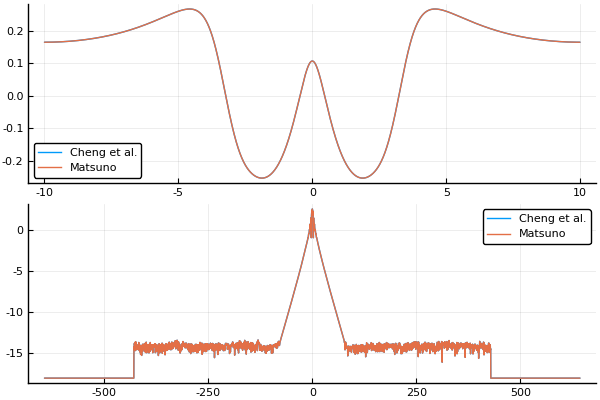

In [30]:
results = Dict()

for model in [Matsuno(freq, epsilon), Cheng(freq, epsilon)]

    h .= exp.(-mesh.x.^2)
    h .= Pi .* fft(h)
    fill!(u, 0)
    u .= Pi .* fft(u)
        
    @time results[model.label] = solve(matsuno, h, u, times, solver )
end

p1 = fig(5, times, results, mesh, Gamma, freq)    